# Kaggle Monet GAN

This notebook uses this tutorial for reference: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

Generative deep learning models are a class of neural networks that learn to produce new data samples that closely resemble the data they were trained on. Instead of merely recognizing patterns in input data (like many traditional models do), generative models aim to *create* similar-looking yet entirely new examples, whether these are images, text, audio, or other structured data forms.

**Key Concepts:**
- **Data Distribution Learning:** Generative models attempt to learn an underlying probability distribution of the training data. By doing so, they can sample from this learned distribution to generate new data that shares similar characteristics.
- **Unsupervised or Semi-Supervised Training:** Often, these models use unlabeled data, making them powerful tools in situations where labeling is expensive or impractical.

**Generative Adversarial Networks (GANs):**  
GANs, introduced by Ian Goodfellow and colleagues in 2014, are a popular and highly effective class of generative models. They consist of two main components:
1. **Generator (G):** Produces synthetic data (e.g., images) from random noise or latent variables.
2. **Discriminator (D):** Distinguishes between real data from the training set and the synthetic data produced by the generator.

**How GANs Work:**
- The generator tries to fool the discriminator by producing increasingly convincing samples.
- The discriminator tries to improve its ability to detect fake samples.
- Through this *adversarial* process, both networks improve: the generator becomes better at creating realistic outputs, and the discriminator becomes more skilled at judging authenticity.

**Outcome:**
The competition drives the generator to produce outputs that closely mimic the real data’s distribution. As a result, well-trained GANs can create highly realistic images, audio, video, or text outputs that are often indistinguishable from real-world samples.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

if tf.config.list_physical_devices('GPU'):
    print('Running on GPU')
    strategy = tf.distribute.MirroredStrategy()
else:
    # Default strategy for CPU
    print('Running on CPU')
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Running on GPU
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


I0000 00:00:1733715750.245560    1222 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733715750.390628    1222 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733715750.390676    1222 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733715750.393628    1222 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733715750.393671    1222 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

2.17.0


In [2]:
GCS_PATH = '.'

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


# Set up our Data Pipeline

The contest dataset uses the tfrecord format to store images, both Monet painting images and the photo test subjects.

We will set up some helper functions to process the data in this format.

In [4]:
IMAGE_SIZE = [256, 256]

def decodeNormalizeImage(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def readTfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decodeNormalizeImage(example['image'])
    return image

In [5]:
def loadData(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(readTfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
monetDs = loadData(MONET_FILENAMES).batch(1)
photoDs = loadData(PHOTO_FILENAMES).batch(1)

Text(0.5, 1.0, 'Monet')

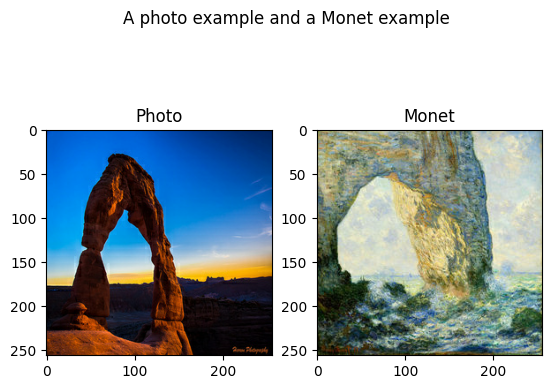

In [7]:
exampleMonet = next(iter(monetDs))
examplePhoto = next(iter(photoDs))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('A photo example and a Monet example')
ax1.imshow(examplePhoto[0] * 0.5 + 0.5)
ax1.set_title('Photo')
ax2.imshow(exampleMonet[0] * 0.5 + 0.5)
ax2.set_title('Monet')

## Model Architecture

### Generator Architecture (U-Net Style)

**Overall Structure:**  
The generator is a U-Net style encoder-decoder architecture with skip connections. The input is an image (e.g., 256x256 pixels with 3 channels). The network encodes the input into a compressed, feature-rich representation through a series of downsampling layers, and then decodes (upsamples) these features back to the original resolution. The skip connections from the encoder stages to the corresponding decoder stages help preserve spatial details, leading to sharper, more detailed outputs.

**Key Components:**

1. **Downsampling Layers (`down_stack`):**  
   Each downsampling layer:
   - Uses `Conv2D` with a stride of 2 to halve the spatial dimensions and increase the number of filters (and thus representation power).
   - May incorporate normalization (e.g., GroupNorm) and a LeakyReLU activation.
   The deeper you go, the more abstract the features become, while spatial size is reduced.  
   
   In the code, you see something like:
   ```python
   down_stack = [
       downsample(64, 4, apply_instancenorm=False), # First layer often no normalization
       downsample(128, 4),
       downsample(256, 4),
       downsample(512, 4),
       ...
       # Typically going down ~7-8 times until a bottleneck is reached
   ]
   ```
   These layers progressively reduce the resolution:  
   256x256 → 128x128 → 64x64 → 32x32 → etc.

2. **Upsampling Layers (`up_stack`):**  
   Each upsampling layer:
   - Uses `Conv2DTranspose` (sometimes called a "deconvolution") to restore spatial resolution.
   - Includes normalization and a ReLU activation.
   - Optionally includes dropout in the upper layers, which can improve robustness and reduce overfitting.

   After upsampling, you concatenate the output of the upsample layer with the corresponding activation from the downsample stage. This "skip connection" transfers fine-grained spatial details lost during downsampling back into the decoding stage, enabling the generator to produce more accurate and detailed output images.

   Example:
   ```python
   up_stack = [
       upsample(512, 4, apply_dropout=True),
       upsample(512, 4, apply_dropout=True),
       upsample(512, 4, apply_dropout=True),
       upsample(512, 4),
       upsample(256, 4),
       upsample(128, 4),
       upsample(64, 4),
   ]
   ```
   This reverses the downsampling process, restoring the image size from a small feature map back to 256x256.

3. **Final Output Layer:**  
   After the last upsampling, there is a final `Conv2DTranspose` layer that maps the decoder output into the desired output shape and channel count, often with a `tanh` activation. The `tanh` activation helps keep output values in a stable range [-1, 1], which is common practice in image synthesis tasks.

### Discriminator Architecture (PatchGAN)

The discriminator is a "PatchGAN" classifier, introduced in Pix2Pix. Instead of making a single "real or fake" decision for the entire image, it outputs a grid of predictions (a patch of values) indicating whether each patch of the input image is real or fake. This makes the discriminator focus on local image details and textures rather than a single global judgment.

**Key Components:**

1. **Input:**  
   Takes an image (256x256x3).

2. **Downsampling Layers:**  
   Just like the generator’s encoder, the discriminator uses a sequence of `Conv2D` layers that downsample the input. Each layer:
   - Increases the number of filters.
   - Uses a stride of 2 for spatial downsampling.
   - Includes normalization (GroupNorm in this code) and a LeakyReLU activation for stable training.

   Example:
   ```python
   down1 = downsample(64, 4, False)(x)  # 128x128x64
   down2 = downsample(128,4)(down1)     # 64x64x128
   down3 = downsample(256,4)(down2)     # 32x32x256
   ```
   
   After several downsamplings, we end with a feature map that captures local image patches at a more abstract level.

3. **Final Layers:**
   After downsampling, the code may:
   - Add a zero-padding layer.
   - Apply one more convolution layer (e.g., 512 filters) with normalization and LeakyReLU.
   - Add another zero-padding layer.
   - Finish with a final `Conv2D` layer (with a single output channel) that produces the patch-level “real/fake” predictions.

   This output is typically a grid of values (e.g., 30x30x1 for a 256x256 input), with each cell in the grid indicating the likelihood that the corresponding patch in the input image is real. The idea is that the discriminator focuses on local details, preventing the generator from simply smoothing over the entire image.

### Putting It All Together (GAN Training)

- **Training Loop:**
  1. **Generator Forward Pass:**  
     The generator takes in an input image (e.g., a source domain image) and produces an output image (e.g., translated into the target domain).
  
  2. **Discriminator Forward Pass:**  
     The discriminator sees both:
     - Real images from the target domain.
     - Generated (fake) images from the generator.
     
     It tries to classify real images as real and generated images as fake.
  
  3. **Loss Functions and Updates:**
     - The generator is trained to "fool" the discriminator, i.e., produce images that the discriminator classifies as real.
     - The discriminator is trained to distinguish generated images from real ones.
  
  By iteratively training them against each other, the generator learns to produce increasingly realistic images, while the discriminator becomes better at spotting fakes, pushing the generator to improve further.

### Summary

- **Generator:** A U-Net style encoder-decoder with skip connections for image-to-image generation tasks. Uses downsampling to encode, upsampling to decode, and skip connections to preserve detail.
- **Discriminator (PatchGAN):** A CNN that classifies local patches of the image as real or fake, encouraging high-quality local detail in the generated images.
  
These two components form a GAN, training in an adversarial loop to produce realistic image translations from one domain to another.

In [13]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [14]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.GroupNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Build the generator

Generator: A U-Net style encoder-decoder with skip connections for image-to-image generation tasks. Uses downsampling to encode, upsampling to decode, and skip connections to preserve detail.

In [15]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Build the discriminator

Discriminator (PatchGAN): A CNN that classifies local patches of the image as real or fake, encouraging high-quality local detail in the generated images.

In [16]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [17]:
# with strategy.scope():
monetGenerator = Generator() # transforms photos to Monet styled paintings
photoGenerator = Generator() # transforms Monet paintings to be like photos

monetDiscriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photoDiscriminator = Discriminator() # differentiates real photos and generated photos

### Build the CycleGAN model

In [18]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monetGenerator,
        photoGenerator,
        monetDiscriminator,
        photoDiscriminator,
        lambdaCycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monetGenerator
        self.p_gen = photoGenerator
        self.m_disc = monetDiscriminator
        self.p_disc = photoDiscriminator
        self.lambdaCycle = lambdaCycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambdaCycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambdaCycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambdaCycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambdaCycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [19]:
# with strategy.scope():
def discriminatorLoss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [20]:
# with strategy.scope():
def generatorLoss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [21]:
# with strategy.scope():
def calcCycleLoss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [22]:
# with strategy.scope():
def identityLoss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [23]:
# with strategy.scope():
monetGeneratorOptimizer = tf.keras.optimizers.Adam()
photoGeneratorOptimizer = tf.keras.optimizers.Adam()

monetDiscriminatorOptimizer = tf.keras.optimizers.Adam()
photoDiscriminatorOptimizer = tf.keras.optimizers.Adam()

In [24]:
# with strategy.scope():
cycleganModel = CycleGan(
    monetGenerator, photoGenerator, monetDiscriminator, photoDiscriminator
)

cycleganModel.compile(
    m_gen_optimizer = monetGeneratorOptimizer,
    p_gen_optimizer = photoGeneratorOptimizer,
    m_disc_optimizer = monetDiscriminatorOptimizer,
    p_disc_optimizer = photoDiscriminatorOptimizer,
    gen_loss_fn = generatorLoss,
    disc_loss_fn = discriminatorLoss,
    cycle_loss_fn = calcCycleLoss,
    identity_loss_fn = identityLoss
)

In [25]:
history1 = cycleganModel.fit(
    tf.data.Dataset.zip((monetDs, photoDs)),
    epochs=25
)

Epoch 1/25


I0000 00:00:1733715853.788761    1812 service.cc:146] XLA service 0x7f0108011b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733715853.788784    1812 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-08 22:44:14.728830: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-08 22:44:17.578636: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1733715890.703330    1812 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - monet_disc_loss: 0.6744 - monet_gen_loss: 4.2123 - photo_disc_loss: 0.6733 - photo_gen_loss: 4.2933
Epoch 2/25
  3/300 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - monet_disc_loss: 0.5573 - monet_gen_loss: 4.6023 - photo_disc_loss: 0.4414 - photo_gen_loss: 4.4675

2024-12-08 22:45:07.612328: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-08 22:45:07.612754: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/andrea/code/Intro to Deep Learning/linvenv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - monet_disc_loss: 0.6461 - monet_gen_loss: 3.1651 - photo_disc_loss: 0.6549 - photo_gen_loss: 3.2072
Epoch 3/25
  3/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - monet_disc_loss: 0.3060 - monet_gen_loss: 4.0756 - photo_disc_loss: 0.4267 - photo_gen_loss: 3.5083

2024-12-08 22:45:23.914644: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - monet_disc_loss: 0.6417 - monet_gen_loss: 2.8671 - photo_disc_loss: 0.6494 - photo_gen_loss: 2.8995
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - monet_disc_loss: 0.6463 - monet_gen_loss: 2.6469 - photo_disc_loss: 0.6478 - photo_gen_loss: 2.6942
Epoch 5/25
  3/300 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - monet_disc_loss: 0.2996 - monet_gen_loss: 3.5099 - photo_disc_loss: 0.4620 - photo_gen_loss: 2.9558

2024-12-08 22:45:57.130546: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - monet_disc_loss: 0.6344 - monet_gen_loss: 2.4828 - photo_disc_loss: 0.6433 - photo_gen_loss: 2.5165
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - monet_disc_loss: 0.6322 - monet_gen_loss: 2.3869 - photo_disc_loss: 0.6435 - photo_gen_loss: 2.4138
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - monet_disc_loss: 0.6367 - monet_gen_loss: 2.3098 - photo_disc_loss: 0.6421 - photo_gen_loss: 2.3347
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - monet_disc_loss: 0.6365 - monet_gen_loss: 2.2430 - photo_disc_loss: 0.6415 - photo_gen_loss: 2.2660
Epoch 9/25
  3/300 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - monet_disc_loss: 0.3090 - monet_gen_loss: 2.9223 - photo_disc_loss: 0.2918 - photo_gen_loss: 3.0827

2024-12-08 22:47:05.738908: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - monet_disc_loss: 0.6306 - monet_gen_loss: 2.1830 - photo_disc_loss: 0.6384 - photo_gen_loss: 2.2141
Epoch 10/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - monet_disc_loss: 0.6304 - monet_gen_loss: 2.1516 - photo_disc_loss: 0.6436 - photo_gen_loss: 2.1608
Epoch 11/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - monet_disc_loss: 0.6272 - monet_gen_loss: 2.1267 - photo_disc_loss: 0.6377 - photo_gen_loss: 2.1310
Epoch 12/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - monet_disc_loss: 0.6274 - monet_gen_loss: 2.1009 - photo_disc_loss: 0.6339 - photo_gen_loss: 2.1099
Epoch 13/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - monet_disc_loss: 0.6256 - monet_gen_loss: 2.0904 - photo_disc_loss: 0.6310 - photo_gen_loss: 2.1074
Epoch 14/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - monet_disc_loss: 0.6262 - monet_gen_loss: 2.0884 - photo_disc_loss: 0.6294 - photo_gen_loss: 2.1065
Epoch 15/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - monet_disc_lo

2024-12-08 22:49:21.869029: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 2.0120 - photo_disc_loss: 0.6190 - photo_gen_loss: 2.0433
Epoch 18/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 1.9965 - photo_disc_loss: 0.6159 - photo_gen_loss: 2.0270
Epoch 19/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.0092 - photo_disc_loss: 0.6128 - photo_gen_loss: 2.0552
Epoch 20/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.0113 - photo_disc_loss: 0.6073 - photo_gen_loss: 2.0623
Epoch 21/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 1.9851 - photo_disc_loss: 0.6023 - photo_gen_loss: 2.0475
Epoch 22/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 1.9778 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.0525
Epoch 23/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - monet_disc_lo

### Fine tune hyperparameters and retrain the model

In [27]:
# with strategy.scope():
monetGeneratorOptimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photoGeneratorOptimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monetDiscriminatorOptimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photoDiscriminatorOptimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [28]:
# with strategy.scope():
cycleganModel2 = CycleGan(
    monetGenerator, photoGenerator, monetDiscriminator, photoDiscriminator
)

cycleganModel2.compile(
    m_gen_optimizer = monetGeneratorOptimizer2,
    p_gen_optimizer = photoGeneratorOptimizer2,
    m_disc_optimizer = monetDiscriminatorOptimizer2,
    p_disc_optimizer = photoDiscriminatorOptimizer2,
    gen_loss_fn = generatorLoss,
    disc_loss_fn = discriminatorLoss,
    cycle_loss_fn = calcCycleLoss,
    identity_loss_fn = identityLoss
)

In [29]:
history2 = cycleganModel2.fit(
    tf.data.Dataset.zip((monetDs, photoDs)),
    epochs=25
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 1.8826 - photo_disc_loss: 0.5824 - photo_gen_loss: 1.9720
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 1.8287 - photo_disc_loss: 0.5521 - photo_gen_loss: 1.9365
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 1.8275 - photo_disc_loss: 0.5473 - photo_gen_loss: 1.9500
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 1.8346 - photo_disc_loss: 0.5439 - photo_gen_loss: 1.9673
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 1.8399 - photo_disc_loss: 0.5396 - photo_gen_loss: 1.9832
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 1.8492 - photo_disc_loss: 0.5342 - photo_gen_loss: 2.0060
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - monet_di

2024-12-08 22:55:16.881777: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 1.8816 - photo_disc_loss: 0.5205 - photo_gen_loss: 2.0620
Epoch 9/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 1.8991 - photo_disc_loss: 0.5127 - photo_gen_loss: 2.1061
Epoch 10/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 1.9235 - photo_disc_loss: 0.5072 - photo_gen_loss: 2.1461
Epoch 11/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 1.9383 - photo_disc_loss: 0.5075 - photo_gen_loss: 2.1934
Epoch 12/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 1.9467 - photo_disc_loss: 0.5108 - photo_gen_loss: 2.2370
Epoch 13/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 1.9532 - photo_disc_loss: 0.5120 - photo_gen_loss: 2.2662
Epoch 14/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - monet_disc_los

It's quite obvious that with fine tuned adam optimizer, loss of the two generators are little bit lower. The decay worked! We decided to choose the generator trained with fine tuned adam optimizer for prediction.

### Visualize our Monet styled photos

W0000 00:00:1733716871.912935    1222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733716871.926152    1222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733716871.927549    1222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733716871.928953    1222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733716871.930385    1222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733716871.931844    1222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733716871.933083    1222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733716871.934390    1222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733716871.935638    1222 gp

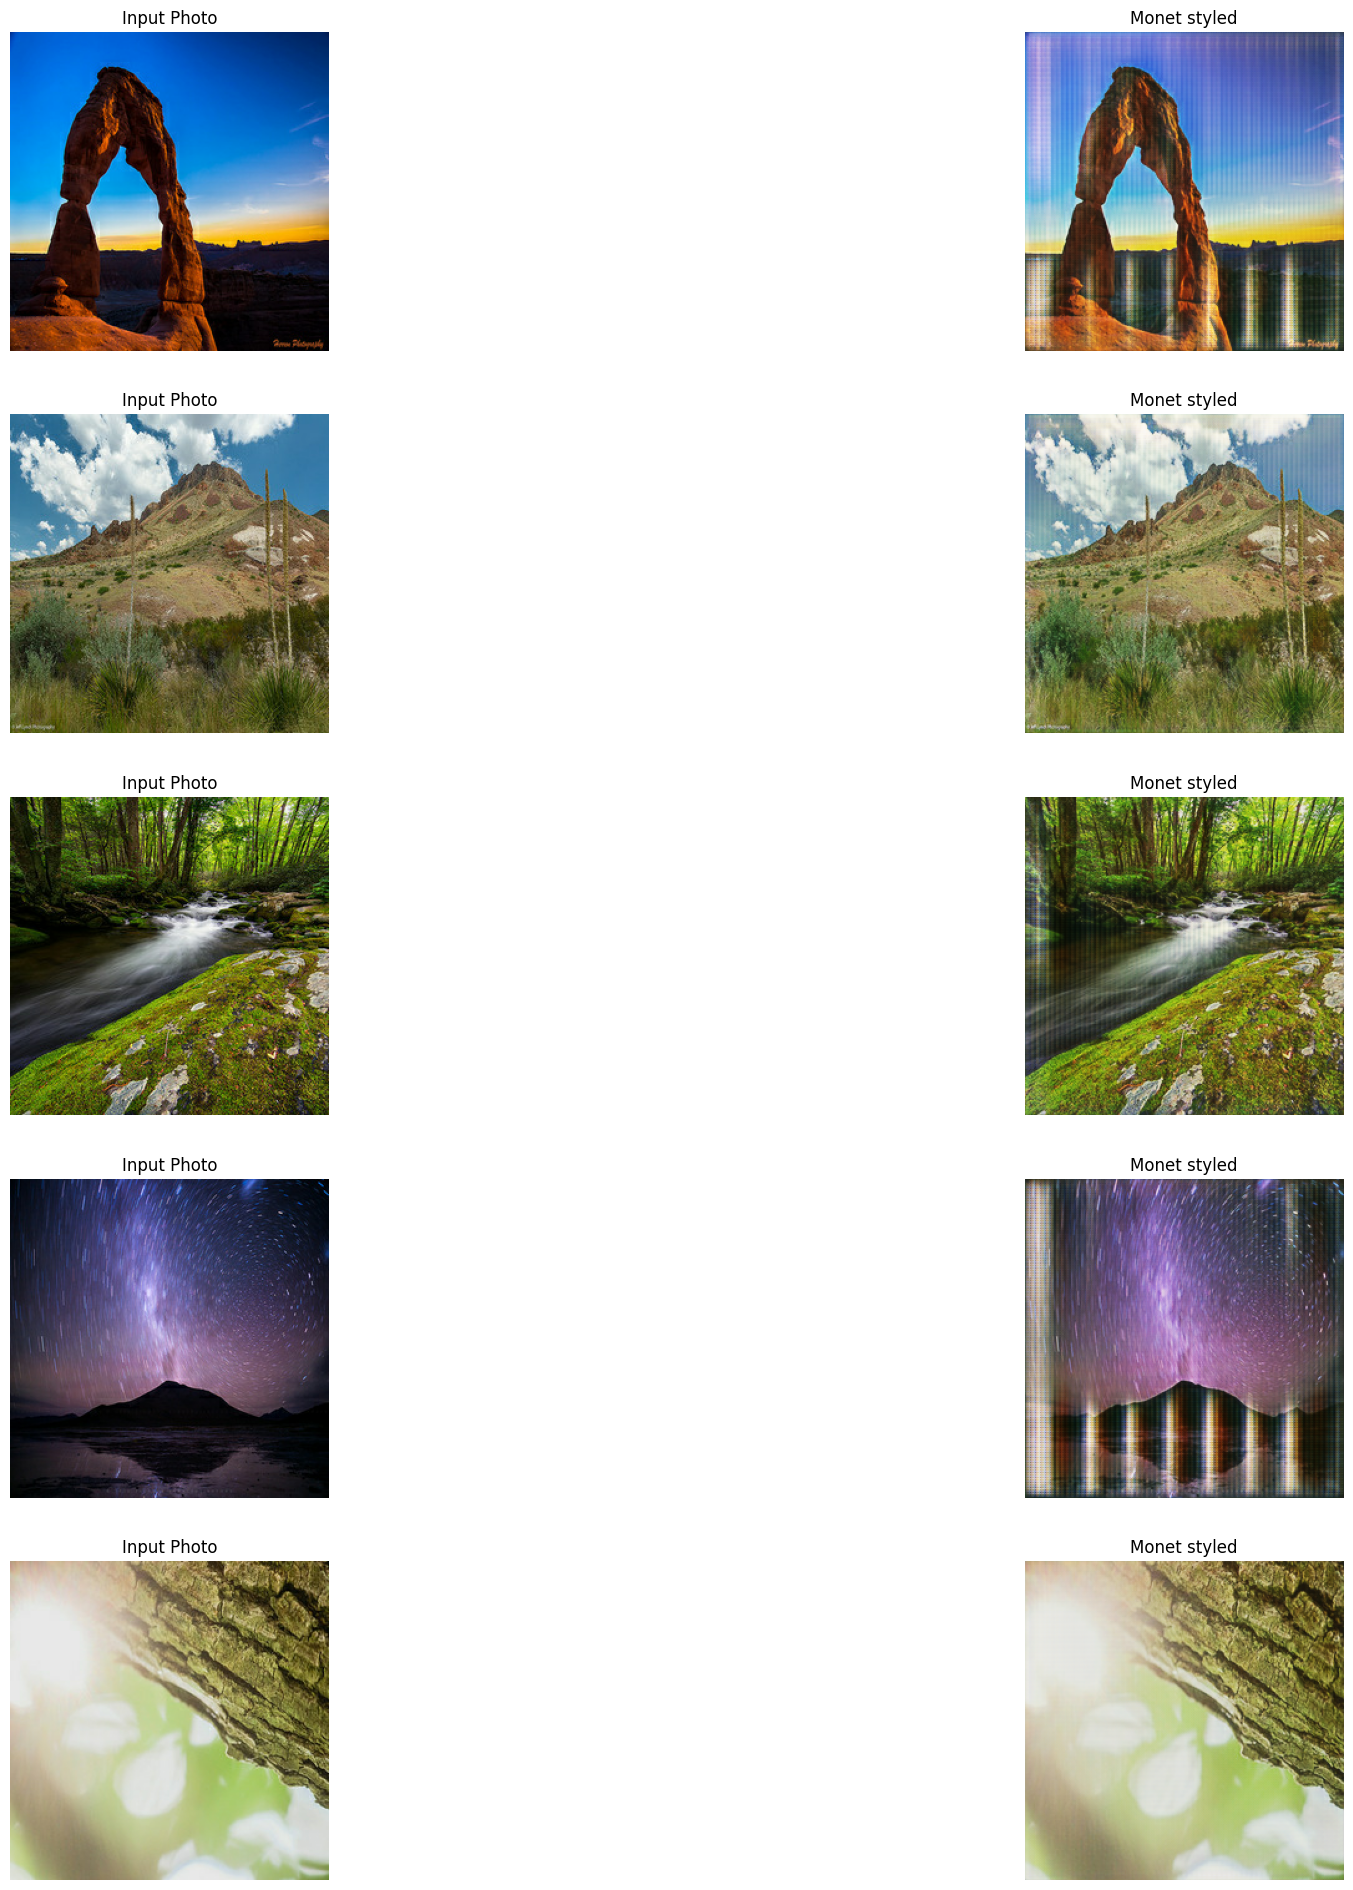

In [31]:
_, ax = plt.subplots(5, 2, figsize=(24, 24))
for i, img in enumerate(photoDs.take(5)):
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet styled")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Create submission file

In [32]:
import PIL
! mkdir images

In [33]:
i = 1
for img in photoDs:
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("images/" + str(i) + ".jpg")
    i += 1

In [34]:
import shutil
shutil.make_archive("images", 'zip', "images")

'/home/andrea/code/Intro to Deep Learning/week5/images.zip'

## Conclusion

In conclusion, our GAN-based approach successfully tackled the Monet Painting Style Transfer competition on Kaggle, demonstrating the power and flexibility of adversarial training for image-to-image translation tasks. By leveraging the U-Net-like generator architecture with skip connections and a PatchGAN discriminator, we achieved visually convincing Monet-like renditions of landscape photos. The careful tuning of hyperparameters, use of normalization layers, and addition of dropout for regularization all contributed to more stable training and higher-quality outputs. Although there is always room for improvement—such as refining the training schedule, exploring alternative normalization methods, or integrating perceptual loss functions—the results obtained here highlight the effectiveness of GANs in generating stylistically coherent and aesthetically pleasing artwork.